#Data and platform setup

Run this scope before anything else at the very first run.<br>
It sets the requirements and loads data needed.<br>

In [26]:
import os
print(os.listdir())

['sample_data', '.config', 'vggish_input.py', 'vggish_params.py', 'vggish_train_demo.py', 'vggish_postprocess.py', 'vggish_inference_demo.py', 'vggish_slim.py', 'vggish_smoke_test.py', 'adc.json', '__pycache__', 'mel_features.py', 'data_v_7_stc', 'vggish_audioset_weights_without_fc2.h5', 'preprocessed.npz']


In [2]:
!pip install catboost==0.8.1.1
!pip install tensorboardX
!pip install tqdm
!pip install resampy six
!pip install librosa

    100% |████████████████████████████████| 33.6MB 1.1MB/s 
    100% |████████████████████████████████| 71kB 5.8MB/s 
    100% |████████████████████████████████| 327kB 19.5MB/s 
    100% |████████████████████████████████| 1.9MB 13.6MB/s 
    100% |████████████████████████████████| 15.9MB 2.3MB/s 
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built resampy
    100% |████████████████████████████████| 1.6MB 13.1MB/s 
  Running setup.py bdist_wheel for librosa ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
Successfully built librosa audioread


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '1_UQRTDw_lQfF6e6QoqojGrG1J5Rzpxee' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('db.7z')

In [0]:
!7z x "db.7z" -y >/dev/null
!rm db.7z

In [0]:
file_id = '1zuxfNjxjSMbNfdeQkQC1lvzQ5VhESj-_' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('vggish.zip')

In [0]:
!unzip -q vggish.zip
!rm vggish.zip

In [0]:
file_id = '16JrWEedwaZFVZYvn1woPKCuWx85Ghzkp' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('vggish_audioset_weights_without_fc2.h5')

In [0]:
file_id = '1TsCC9EfYpze0gWsD7wxQ-PDebcdP4B0c' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('preprocessed.npz')

In [0]:
file_id = '1ZVbxzcGEJbLj7lq7EKyX0MSrZz0e3UgW' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('model.npz')

#Intro

The task is to classify sound events.<br>
There are 8 classes:

*   Background
*   Bags
*   Door
*   Keyboard
*   Knocking
*   Ring
*   Speech
*   Tool

The metric used is accuracy.


One rarely works with raw, temporal data.<br>
Thus, we have to pre-process data somehow.

We will consider 2 wavs (knocking and speech examples) from the database to show how the pre-processing works and looks.

In [0]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt

knocking = 'data_v_7_stc/audio/knocking_door_0007.wav'
speech = 'data_v_7_stc/audio/speech_0029.wav'

There are two theories of a human hearing - place ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based) and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) ) In sound recognition, there are two main tendencies - to input spectrogram (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients.<br>
Here below 4 ways to represent wav file as data convenient for further processing:

*   Spectrogram
*   Log-spectrogram
*   Mel-spectrogram
*   MFCC



In [0]:
# Frequencies are in range (0, 8000) according to Nyquist theorem (https://en.wikipedia.org/wiki/Nyquist_rate)
def specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10, log=False):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps) if log else spec

def raw_view(filename):
    sample_rate, samples = wavfile.read(filename)
    plt.figure(figsize=(16, 4))
    plt.title('Raw wave of ' + filename)
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(samples)), samples)
    plt.show()

def spec_view(filename, mode='log'):
    sample_rate, samples = wavfile.read(filename)
    plt.figure(figsize=(16, 4))
    if mode=='log':
        freqs, times, spectrogram = specgram(samples, sample_rate, log=True)
        plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
                   extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        plt.yticks(freqs[::16])
        plt.xticks(times[::16])
        plt.title('Log Spectrogram of ' + filename)
        plt.ylabel('Freqs in Hz')
        plt.xlabel('Time')
        plt.show()
    elif mode=='default':
        freqs, times, spectrogram = specgram(samples, sample_rate, log=False)
        plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
                   extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        plt.yticks(freqs[::16])
        plt.xticks(times[::16])
        plt.title('Spectrogram of ' + filename)
        plt.ylabel('Freqs in Hz')
        plt.xlabel('Time')
        plt.show()
    elif mode=='mel':
        S = librosa.feature.melspectrogram(samples.astype(np.float32), sr=sample_rate, n_mels=128)
        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.title('Mel power spectrogram of ' + filename)
        plt.colorbar(format='%+02.0f dB')
        plt.tight_layout()
    elif mode=='mfcc':
        S = librosa.feature.melspectrogram(samples.astype(np.float32), sr=sample_rate, n_mels=128)
        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
        # Let's pad on the first and second deltas while we're at it
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        librosa.display.specshow(delta2_mfcc)
        plt.ylabel('MFCC')
        plt.xlabel('Time')
        plt.title('MFCC coeffs of ' + filename)
        plt.colorbar()
        plt.tight_layout()
    else:
        raise NotImplementedError

But firstly, what is spectrogram?<br>
The raw view of the wave are quite familiar ofr us, but how to work with this below?

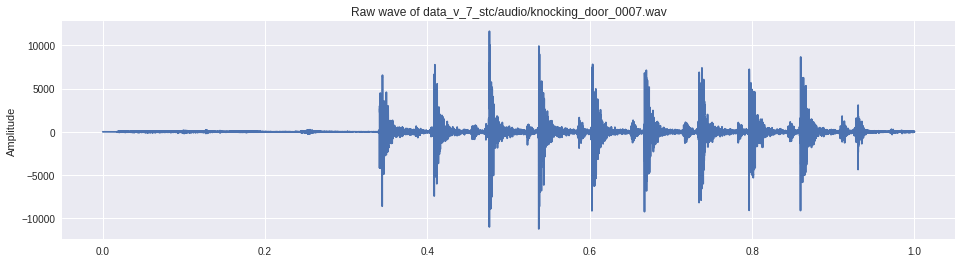

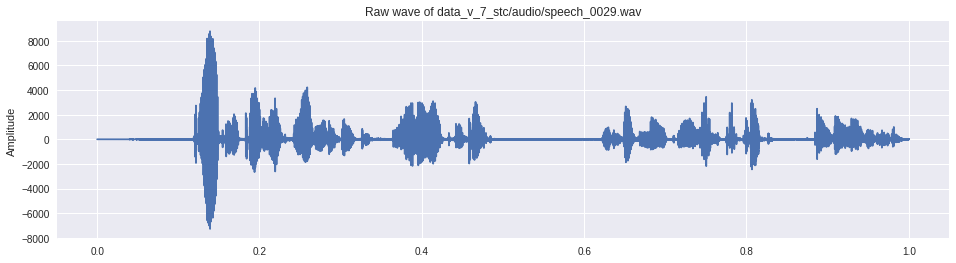

In [13]:
raw_view(knocking)
raw_view(speech)

So, [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) is the square of the magnitude of the [Short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT)<br>
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/ef3a0f202b69189d93454a2373182f6f0d926992)<br>
where STFT is<br>
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/ba7a721b6f51bd85e177663e30decf885862d160)<br>
where *w* is a [window function](https://en.wikipedia.org/wiki/Window_function) (commonly a [Hann window](https://en.wikipedia.org/wiki/Window_function#Hann_window))

Let us look at spectrograms of our examples

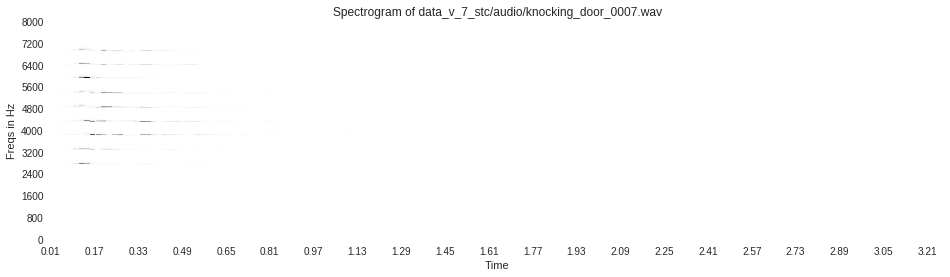

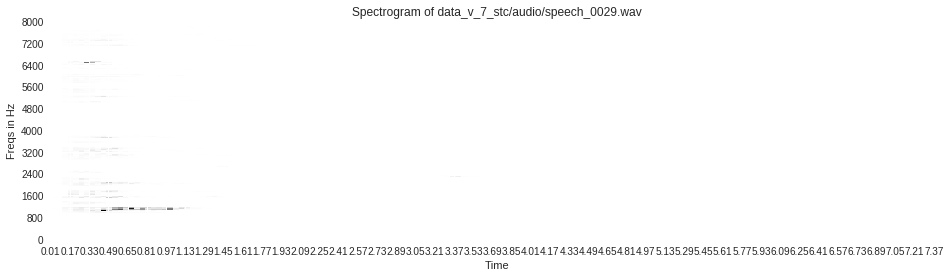

In [14]:
spec_view(knocking, mode='default')
spec_view(speech, mode='default')

Not so representative, isn't it?<br>
It is more practical to use log spectrogram.

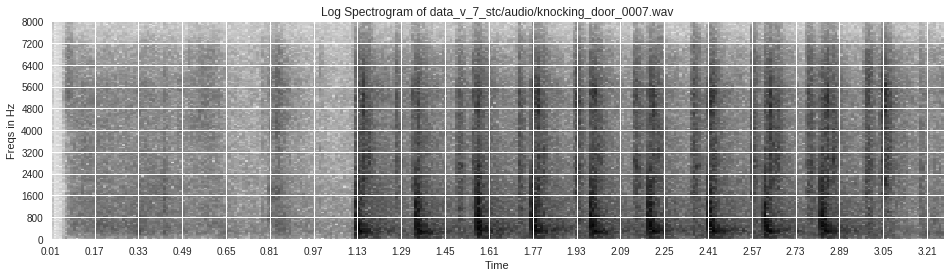

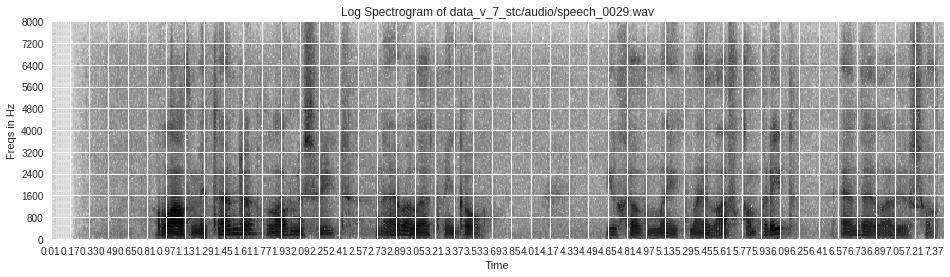

In [15]:
spec_view(knocking, mode='log')
spec_view(speech, mode='log')

Using Mel power spectrogram is even more beautiful.  
To calculate Mel power spectrogram and MFCC we use librosa python package.<br>
Useful reference:[ MFCC explained](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

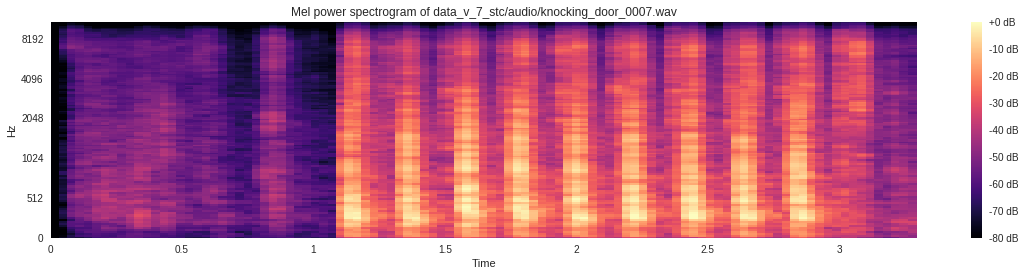

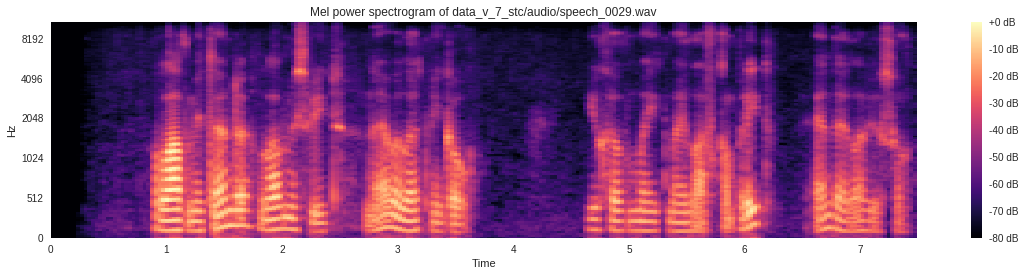

In [16]:
spec_view(knocking, mode='mel')
spec_view(speech, mode='mel')

Mel power spectrogram is constructed as following:

MFCC (Mel frequency cepstral coefficients) appeared to be very efficient in sound processing problems.


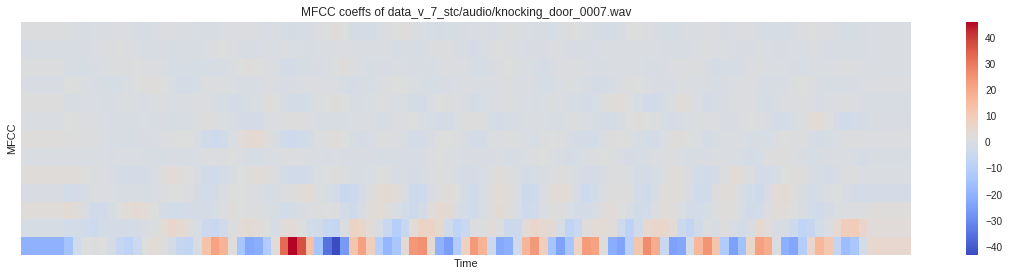

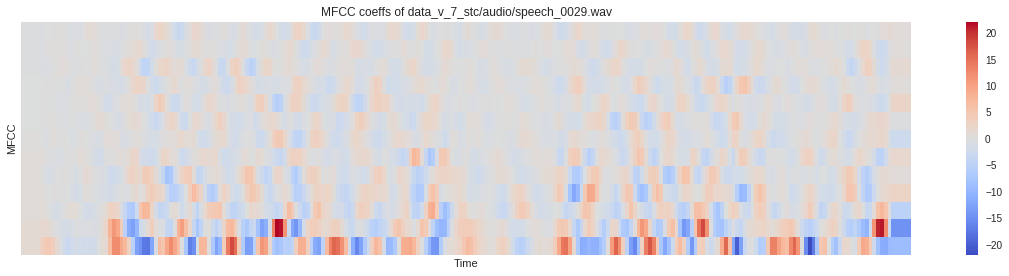

In [17]:
spec_view(knocking, mode='mfcc')
spec_view(speech, mode='mfcc')

MFCC are calculated in a following way
1. Frame the signal into short frames.
2. For each frame calculate the periodogram estimate of the power spectrum.
3. Apply the mel filterbank to the power spectra, sum the energy in each filter.
4. Take the logarithm of all filterbank energies.
5. Take the (Discrete Cosine Transform) of the log filterbank energies.

Now, step by step:
1. Splitting the signal should be clear, we just get small frames with 25ms length and 15ms overlap
2. Estimating power spectrum:  
We multiply frame by Hamming window function
$$w[n]=0.54−0.46cos(\frac{2πn}{N−1})$$
where $N$ is length of frame  
<img src="https://haythamfayek.com/assets/posts/post1/hamming_window.jpg" width="300px">  
That is required for STFT assumptions to take place.
Then we estimate the power of signal as following:
$$P=\frac{|STFT(x_i)|^2}{N}$$  
3. Then we apply 26 Mel triangular filters to $P$
<img src="http://www.practicalcryptography.com/media/miscellaneous/files/mel_filterbank_example.png">
4. Take the logarithm for calculated values and then perform DCT


As you might have noticed, spectrogram examples above have different timelength.<br>
There are two approaches to unify the length:

*   Sliding window (with no overlapping and zero padding)
*   Adaptive pooling



#My model

Now let us consider my solution of the task.<br>
The main idea of the solution is to use [VGGish](https://github.com/tensorflow/models/tree/1b728d473949c27ad93b90a16e2585ede407ad2f/research/audioset) preprocessing along with pre-trained convolution [layers](https://drive.google.com/open?id=16JrWEedwaZFVZYvn1woPKCuWx85Ghzkp).<br>
VGGish is a VGG-like model along with pre-processing.<br>
Interested one can look at this [notebook](https://colab.research.google.com/drive/1TbX92UL9sYWbdwdGE0rJ9owmezB-Rl1C#scrollTo=PAE4O-fK-RW2).



There was two problems to handle:<br>

*   [AudioSet](https://research.google.com/audioset/) (the database used to train the VGGish net) contains no background and all data have a fixed length (10 sec).


> So the first step here is to separate the background. It is achieved by [Catboost](https://tech.yandex.ru/catboost/) on 4 simple features: mean, std, min, max.<br>

*   The database contains very short files (<1sec).<br>
It appears that the most of the files of less than 1 sec length are belong to a single class. Thus, we can check and predict them separately.

In [0]:
import os
import wave
import keras
import sklearn
import warnings
import vggish_input
import numpy as np
import tensorflow as tf
import pandas as pd
import catboost as cb
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.metrics import categorical_accuracy
from keras.layers import Dense, concatenate, Activation, Dropout, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Model
from keras.regularizers import l2
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam
from scipy.stats import mode as Mode

warnings.filterwarnings("ignore")

In [0]:
NUM_CLASSES = 8
NUM_CLASSES_NET = NUM_CLASSES - 1
NUM_EPOCH = 3
NUM_NETS = 5
PREPROCESSED_DATA_FILENAME = 'preprocessed.npz'
np.random.seed(123)
tf.set_random_seed(123)

Load train database

In [42]:
meta = pd.read_csv('./data_v_7_stc/meta/meta.txt', sep='\t', header=None, names=['name', 'class'], usecols=[0, 4], index_col=0)
le = LabelEncoder()
meta['class'] = le.fit_transform(meta['class'])
meta.head()

,class
name,
background_0001.wav,0
background_0001_time_stretch_0.wav,0
background_0001_time_stretch_1.wav,0
background_0001_time_stretch_10.wav,0
background_0001_time_stretch_11.wav,0


What is inside of VGGish preprocessing?<br>
*  All audio is resampled to 16 kHz mono.
*  A spectrogram is computed using magnitudes of the Short-Time Fourier Transform with a window size of 25 ms, a window hop of 10 ms, and a periodic Hann window.
*  A mel spectrogram is computed by mapping the spectrogram to 64 mel bins covering the range 125-7500 Hz.
*  A stabilized log mel spectrogram is computed by applying log(mel-spectrum + 0.01) where the offset is used to avoid taking a logarithm of zero.
*  These features are then framed into non-overlapping examples of 0.96 seconds, where each example covers 64 mel bands and 96 frames of 10 ms each.

Here below we use VGGish preprocessing for every class except *background*.<br>
Thus, we get train set for the model and train set for the background filter.

In [0]:
if os.path.exists(PREPROCESSED_DATA_FILENAME):
    data = [d[-1] for d in np.load(PREPROCESSED_DATA_FILENAME).items()]
    X_train, Y_train, X_filter, Y_filter, aposteriori_prob = data
else:
    aposteriori_prob = np.zeros(NUM_CLASSES, dtype=np.int)

    def prepare_data(df):
        X_net, Y_net, X_filter, Y_filter = [], [], [], []
        for index, row in tqdm(df.iterrows(), total=df.size):
            wav = wave.open('./data_v_7_stc/audio/' + index, mode="r")
            frames = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
            X_filter += [[np.mean(frames), np.std(frames), np.min(frames), np.max(frames)]]
            Y_filter += [0 if row['class'] == 0 else 1]
            if row['class'] != 0:
                _, _, rate, length, _, _ = wav.getparams()
                if rate <= length:
                    examples = vggish_input.wavfile_to_examples('./data_v_7_stc/audio/' + index)
                    X_net += [ex for ex in examples]
                    Y_net += [row['class'] - 1 for ex in examples]
                else:
                    aposteriori_prob[row['class']] += 1
        X_net = np.array(X_net)[..., None]
        Y_net = np.array(Y_net)
        return X_net, Y_net, X_filter, Y_filter

    X_train, Y_train, X_filter, Y_filter = prepare_data(meta)
    aposteriori_prob = aposteriori_prob / aposteriori_prob.sum()
    np.savez(PREPROCESSED_DATA_FILENAME, X_train, Y_train, X_filter, Y_filter, aposteriori_prob)

Background filter training

In [0]:
background_filter = cb.CatBoostClassifier(iterations=NUM_EPOCH, depth=4, learning_rate=0.1, loss_function='Logloss', custom_loss=['Accuracy'], random_seed=123, logging_level='Silent')
background_filter.fit(X_filter, Y_filter, verbose=False);

Load test database

In [0]:
listdir_test = pd.Series(dict((name, name.split('_')[0]) for name in os.listdir('./data_v_7_stc/test')))
listdir_test[listdir_test == 'knocking'] = 'knocking_door'
listdir_test_short = pd.Series(le.transform(listdir_test[listdir_test != 'unknown']), index=listdir_test.index[listdir_test != 'unknown'])

Let us look at VGGish net architecture

In [60]:
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras import backend as K

import vggish_params as params


# weight path
WEIGHTS_PATH = './vggish_audioset_weights_without_fc2.h5'
WEIGHTS_PATH_TOP = './vggish_audioset_weights.h5'

def VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=True, pooling='avg'):
    '''
    An implementation of the VGGish architecture.
    :param load_weights: if load weights
    :param weights: loads weights pre-trained on a preliminary version of YouTube-8M.
    :param input_tensor: input_layer
    :param input_shape: input data shape
    :param out_dim: output dimension
    :param include_top:whether to include the 3 fully-connected layers at the top of the network.
    :param pooling: pooling type over the non-top network, 'avg' or 'max'
    :return: A Keras model instance.
    '''

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = params.EMBEDDING_SIZE

    # input shape
    if input_shape is None:
        input_shape = (params.NUM_FRAMES, params.NUM_BANDS, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor



    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_1')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_1')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)



    if include_top:
        # FC block
        x = Flatten(name='flatten_')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_1')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_2')(x)
        x = Dense(out_dim, activation='relu', name='vggish_fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = aud_input
    # Create model.
    model = Model(inputs, x, name='VGGish')


    # load weights
    if load_weights:
        if weights == 'audioset':
            if include_top:
                model.load_weights(WEIGHTS_PATH_TOP)
            else:
                model.load_weights(WEIGHTS_PATH)
        else:
            print("failed to load weights")

    return model

model_v = VGGish(include_top=False)
for layer in model_v.layers:
    layer.trainable = False

model_v.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3/conv3_1 (Conv2D)       (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3/conv3_2 (Conv2D)       (None, 24, 16, 256)       590080    
__________

Now we put our dense layers on the top of VGGish convolutional layers.<br>
Also we exclude conv layers from the training.

Another problem is that model accuracy is unstable due to randomness and insufficient database.<br>
So, to stabilize the result, 5 nets are trained and transformed to a new net with average weights.

In [47]:
MODEL_NAME = 'model.h5'
if os.path.exists(MODEL_NAME):
    avg_model = get_model(model_v)
    avg_model.load_weights('model.h5')
else:
    def get_model(model_bottom):
        x = model_bottom.get_layer(name="conv4/conv4_2").output
        x = Flatten(name='flatten_')(x)
        x = Dense(512, activation=keras.backend.relu, name='vggish_fc1/fc1_1')(x)
        x = Dropout(0.25, name='dropout_1')(x)
        x = Dense(512, activation=keras.backend.relu, name='vggish_fc1/fc1_2')(x)
        x = Dropout(0.25, name='dropout_2')(x)
        x = Dense(NUM_CLASSES_NET, activation=keras.backend.softmax, name='vggish_fc2')(x)
        model = Model(model_bottom.input, x, name='my_VGGish')
        model.compile(optimizer=Adam(amsgrad=True), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    model_v = VGGish(include_top=False)
    for layer in model_v.layers:
        layer.trainable = False

    models = []
    for i in range(NUM_NETS):
        print()
        print('Training Net '+ str(i))
        print()
        model = get_model(model_v)
        model.fit(X_train, Y_train, epochs=NUM_EPOCH, verbose=2, batch_size=32)
        models += [model]

    avg_model = get_model(model_v)
    weights = [model.get_weights() for model in models]
    new_weights = []
    for weights_list_tuple in zip(*weights):
        new_weights.append(
            [np.array(weights_).mean(axis=0)\
                for weights_ in zip(*weights_list_tuple)])
    avg_model.set_weights(new_weights)
avg_model.summary()


Training Net 0

Epoch 1/3
 - 99s - loss: 0.0939 - acc: 0.9702
Epoch 2/3
 - 95s - loss: 0.0139 - acc: 0.9958
Epoch 3/3
 - 95s - loss: 0.0055 - acc: 0.9983

Training Net 1

Epoch 1/3
 - 97s - loss: 0.0926 - acc: 0.9708
Epoch 2/3
 - 95s - loss: 0.0127 - acc: 0.9961
Epoch 3/3
 - 95s - loss: 0.0064 - acc: 0.9980

Training Net 2

Epoch 1/3
 - 97s - loss: 0.0922 - acc: 0.9714
Epoch 2/3
 - 95s - loss: 0.0148 - acc: 0.9957
Epoch 3/3
 - 95s - loss: 0.0057 - acc: 0.9983

Training Net 3

Epoch 1/3
 - 97s - loss: 0.0918 - acc: 0.9706
Epoch 2/3
 - 95s - loss: 0.0134 - acc: 0.9957
Epoch 3/3
 - 96s - loss: 0.0072 - acc: 0.9975

Training Net 4

Epoch 1/3
 - 97s - loss: 0.0923 - acc: 0.9717
Epoch 2/3
 - 96s - loss: 0.0129 - acc: 0.9961
Epoch 3/3
 - 96s - loss: 0.0088 - acc: 0.9974


Time to test our model

In [0]:
def predict(model):
    known, known_mask, pred, pred_proba = [], [], [], []
    for name in tqdm(listdir_test.index, total=listdir_test.size):
        if listdir_test[name] == 'unknown':
            known_mask += [False]
        else:
            known += [listdir_test_short[name]]
            known_mask += [True]
        wav = wave.open('./data_v_7_stc/test/' + name, mode="r")
        frames = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        filter_proba = background_filter.predict_proba([np.array([np.mean(frames), np.std(frames), np.min(frames), np.max(frames)])])
        filter_ans = np.argmax(filter_proba)
        if filter_ans == 0:
            pred += [filter_ans]
            pred_proba += [filter_proba[0][filter_ans]]
        else:
            _, _, rate, length, _, _ = wav.getparams()
            if rate <= length:
                example = vggish_input.wavfile_to_examples('./data_v_7_stc/test/' + name)
                ans, ans_proba = [], []
                pred_batch = model.predict(np.array(example[..., None]))
                pred_elem = np.zeros(NUM_CLASSES_NET)
                for i in pred_batch:
                    for j in range(NUM_CLASSES_NET):
                        pred_elem[j] += i[j] / len(pred_batch)
                ans = np.argmax(pred_elem)
                pred += [ans + 1]
                pred_proba += [pred_elem[ans]]
            else:
                pred += [np.argmax(aposteriori_prob)]
                pred_proba += [aposteriori_prob[pred[-1]]]
    pred = np.array(pred, dtype=np.int)
    pred_proba = np.array(pred_proba)
    known = np.array(known)
    known_mask = np.array(known_mask)
    return len(pred[known_mask][pred[known_mask] == known]) / len(known), pred, pred_proba

In [59]:
expected_accuracy, pred_class, pred_proba = predict(avg_model)
print('Expected accuracy: ' + str(expected_accuracy))

with open('result.txt', 'w') as fw:
    for i in range(listdir_test.size):
        fw.write(listdir_test.index[i] + '\t' + '{:.3f}'.format(pred_proba[i]) + '\t' + le.inverse_transform(pred_class[i]) + '\n')

100%|██████████| 610/610 [00:24<00:00, 25.37it/s]


Expected accuracy: 0.9534883720930233
